<a href="https://colab.research.google.com/github/profedaniel86/Series_de_Tiempo/blob/main/.%20Protocolos_Bayes/Arima_bayes_ventana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

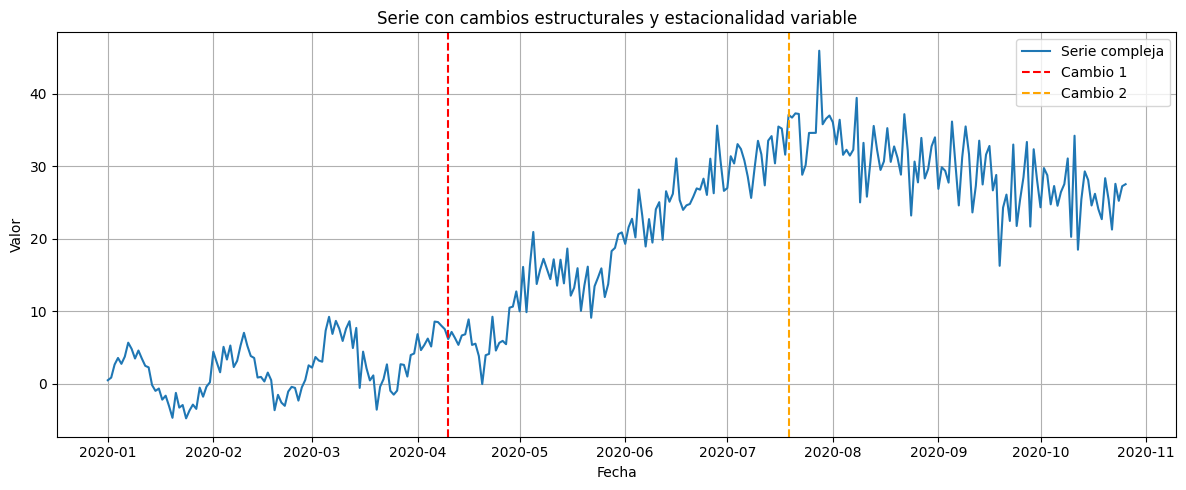

In [1]:

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import optuna
import numpy as np
import pandas as pd
import warnings
import optuna


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
n = 300
t = np.arange(n)

# Ruido con varianza creciente
ruido = np.random.normal(0, 1 + 0.01 * t)

# Tendencia con ruptura
tendencia = np.piecewise(t,
                         [t < 100, (t >= 100) & (t < 200), t >= 200],
                         [lambda t: 0.05 * t,
                          lambda t: 0.3 * (t - 100) + 5,
                          lambda t: -0.1 * (t - 200) + 35])

# Estacionalidad con cambio de periodo
estacionalidad = np.piecewise(t,
                               [t < 150, t >= 150],
                               [lambda t: 5 * np.sin(2 * np.pi * t / 30),
                                lambda t: 2 * np.sin(2 * np.pi * t / 15)])

# Serie total
serie = tendencia + estacionalidad + ruido
serie = pd.Series(serie, index=pd.date_range("2020-01-01", periods=n, freq='D'))


plt.figure(figsize=(12, 5))
plt.plot(serie, label="Serie compleja")
plt.axvline(serie.index[100], color='red', linestyle='--', label="Cambio 1")
plt.axvline(serie.index[200], color='orange', linestyle='--', label="Cambio 2")
plt.title("Serie con cambios estructurales y estacionalidad variable")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

def evaluar_expanding_forecast(serie, order, window=12, step_size=1, horizon=1, metric='rmse'):
    """
    Simula pronósticos autoregresivos en tiempo real con ventana expandida desde el inicio.
    
    Parámetros:
        serie     : serie temporal (pd.Series)
        order     : tupla ARIMA (p,d,q)
        window    : cantidad de pronósticos (desde el final hacia atrás)
        step_size : cada cuántos puntos se hace un pronóstico
        horizon   : cuántos pasos adelante predices en cada punto
        metric    : 'rmse' o 'mae'

    Retorna:
        Error promedio global (RMSE o MAE) entre todos los valores predichos vs observados.
    """
    n = len(serie)
    predichos = []
    observados = []

    puntos_finales = list(range(n - window * step_size, n - horizon + 1, step_size))

    for end_train in puntos_finales:
        train = serie[:end_train]
        test = serie[end_train:end_train + horizon]

        if len(test) < horizon:
            continue

        try:
            model = ARIMA(train, order=order, enforce_stationarity=False, enforce_invertibility=False).fit()
            pred = model.forecast(steps=horizon)

            predichos.extend(pred)
            observados.extend(test)

        except:
            continue

    if len(predichos) == 0:
        return np.inf

    predichos = np.array(predichos)
    observados = np.array(observados)

    if metric == 'rmse':
        return np.sqrt(mean_squared_error(observados, predichos))
    elif metric == 'mae':
        return np.mean(np.abs(observados - predichos))
    else:
        raise ValueError("Metric must be 'rmse' or 'mae'")


In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def objective(trial):
    
    p = trial.suggest_int("p", 1, 10)
    d = trial.suggest_int("d", 1, 3)
    q = trial.suggest_int("q", 1, 10)
    
    order = (p, d, q)
    return evaluar_expanding_forecast(serie, order, window=12, step_size=1, horizon=2)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20,  )

[I 2025-06-13 15:44:50,067] A new study created in memory with name: no-name-7f5b5bb9-47f8-4dd0-bac1-4b980e58f2ba
[I 2025-06-13 15:44:53,568] Trial 0 finished with value: 2.577546760731113 and parameters: {'p': 4, 'd': 3, 'q': 5}. Best is trial 0 with value: 2.577546760731113.
[I 2025-06-13 15:44:56,604] Trial 1 finished with value: 2.303586895023784 and parameters: {'p': 2, 'd': 2, 'q': 7}. Best is trial 1 with value: 2.303586895023784.
[I 2025-06-13 15:45:01,882] Trial 2 finished with value: 2.2316504967275903 and parameters: {'p': 6, 'd': 1, 'q': 10}. Best is trial 2 with value: 2.2316504967275903.
[I 2025-06-13 15:45:05,694] Trial 3 finished with value: 2.38133937378292 and parameters: {'p': 7, 'd': 3, 'q': 5}. Best is trial 2 with value: 2.2316504967275903.
[I 2025-06-13 15:45:11,253] Trial 4 finished with value: 2.2909239103395085 and parameters: {'p': 9, 'd': 2, 'q': 8}. Best is trial 2 with value: 2.2316504967275903.
[I 2025-06-13 15:45:13,852] Trial 5 finished with value: 2.10

: 

## Taller en Clase: Pronóstico del Número de Ocupados
### Objetivo del taller:

Empleando la información del número de ocupados (en miles de personas) para las 13 principales ciudades del país, construya un modelo de pronóstico para los próximos 6 meses utilizando los métodos de suavización exponencial vistos en clase, considerando versiones aditivas o multiplicativas según la naturaleza de la serie. Para ajustar los hiperparámetros del modelo (como alpha, beta y gamma), utilice optimización bayesiana a través de la librería Optuna, definiendo un espacio de búsqueda adecuado. La evaluación del modelo debe realizarse mediante un protocolo de validación temporal, utilizando una ventana móvil o recursiva, y empleando métricas apropiadas como RMSE.

Una vez ajustado el modelo, compárelo con el mejor modelo obtenido en el ejercicio anterior. Luego, elabore un informe breve (máximo una página de texto) explicando  los resultados obtenidos y las proyecciones generadas, incluyendo las predicciones para los próximos 6 meses, mencione las principales limitaciones del pronóstico.

